<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ClassificationWithPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook does PCA on MNIST**




In [1]:
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%pylab inline
import pickle
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
pca_path = './gdrive/My Drive/PCA/mnist/'

In [5]:
from sklearn.decomposition import PCA

mask = np.where(np.var(x_train, axis=0)>0.)
num  = len(mask[0])
print(num)
for ii in range(10):
  indices = np.where(targets_train==ii)
  x_train_class = x_train[indices]
  cut_train = x_train_class[:,mask[0]]
  pca = PCA(svd_solver='full',n_components=num)
  pca.fit(cut_train)  

  pickle.dump([pca,mask], open(pca_path+'pca_on_%d_num_comp_full.pkl'%ii,'wb'))



717


In [0]:
import numpy.linalg as lg
def get_probability_of_data(logdet,Cinv,data):
  d    = len(data)
  Cinv_d = np.einsum('jk,...k->...j',Cinv,data)
  logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d)
  return logprob

In [8]:
# do classification
nums = [10,20,30,40,50,60,70,80,90,100,200,300,400,500]
acc1 = np.zeros((len(nums),10))
acc2 = np.zeros((len(nums),10))

for ll in range(len(nums)):
  num = nums[ll] 
  print(num, ll)
  for ii in range(10):
    print(ii)
    indices = np.where(targets_test==ii)
    x_test_class =x_test[indices]
    logprob1=[]
    logprob2=[]
    for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      cut_test = x_test_class[:,mask[0]]
      sing     = pca.singular_values_[0:num]
      R        = pca.components_[0:num]
      sigma2_1 = pca.explained_variance_[num]
      sigma2_2 = np.mean(pca.explained_variance_[num::])
      
      C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_1
      sign ,logdetC = lg.slogdet(C_)
      logprob1+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
      C_       = np.dot(R.T,np.dot(np.diag(sing), R))+np.eye(len(R.T))*sigma2_2
      sign ,logdetC = lg.slogdet(C_)
      logprob2+=[get_probability_of_data(logdetC,lg.inv(C_),cut_test)]
      
    logprob1=np.asarray(logprob1)
    correct = len(np.where(np.argsort(logprob1, axis=0)[-1]==ii)[0])
    acc_1 = np.float(correct)/np.float(len(x_test_class))
    print('acc 1:', acc_1)
    acc1[ll,ii]=acc_1
    
    logprob2=np.asarray(logprob2)
    correct = len(np.where(np.argsort(logprob2, axis=0)[-1]==ii)[0])
    acc_2 = np.float(correct)/np.float(len(x_test_class))
    print('acc 2:', acc_2)
    acc2[ll,ii]=acc_2
    
pickle.dump(acc1, open(pca_path+'accuracies1.pkl','wb'))
pickle.dump(acc2, open(pca_path+'accuracies2.pkl','wb'))

10 0
0
acc 1: 0.0
acc 2: 0.9826530612244898
1
acc 1: 1.0
acc 2: 0.8616740088105727
2
acc 1: 0.0
acc 2: 0.9137596899224806
3
acc 1: 0.0
acc 2: 0.9198019801980198
4
acc 1: 0.0
acc 2: 0.9032586558044806
5
acc 1: 0.0
acc 2: 0.9013452914798207
6
acc 1: 0.0
acc 2: 0.9373695198329853
7
acc 1: 0.0
acc 2: 0.9260700389105059
8
acc 1: 0.0
acc 2: 0.9250513347022588
9
acc 1: 0.0
acc 2: 0.9008919722497523
20 1
0
acc 1: 0.025510204081632654
acc 2: 0.9877551020408163
1
acc 1: 1.0
acc 2: 0.9118942731277533
2
acc 1: 0.0
acc 2: 0.9457364341085271
3
acc 1: 0.0
acc 2: 0.9207920792079208
4
acc 1: 0.0
acc 2: 0.9643584521384929
5
acc 1: 0.0
acc 2: 0.9585201793721974
6
acc 1: 0.008350730688935281
acc 2: 0.9613778705636743
7
acc 1: 0.005836575875486381
acc 2: 0.9406614785992218
8
acc 1: 0.0
acc 2: 0.9527720739219713
9
acc 1: 0.0
acc 2: 0.9197224975222993
30 2
0
acc 1: 0.39183673469387753
acc 2: 0.9857142857142858
1
acc 1: 1.0
acc 2: 0.9303964757709251
2
acc 1: 0.0
acc 2: 0.9612403100775194
3
acc 1: 0.0
acc 2: 0

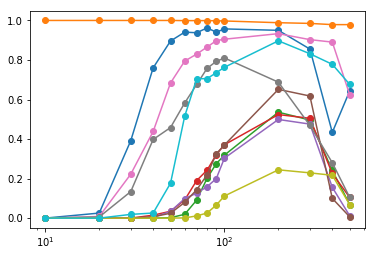

In [12]:
for ii in range(10):
  plt.semilogx(nums, acc1[:,ii], marker='o',label='class %d'%ii)

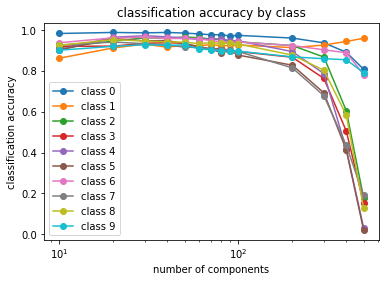

In [17]:
plt.title('classification accuracy by class')
for ii in range(10):
  plt.semilogx(nums, acc2[:,ii], marker='o',label='class %d'%ii)
  plt.xlabel('number of components')
  plt.ylabel('classification accuracy')
  plt.legend()

No handles with labels found to put in legend.


0.9500304766779235


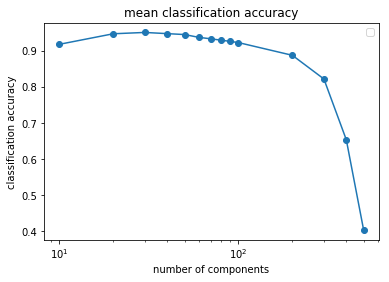

In [20]:
plt.figure()
plt.title('mean classification accuracy')
plt.semilogx(nums, np.mean(acc2,axis=1), marker='o')
print(max(np.mean(acc2,axis=1)))
plt.xlabel('number of components')
plt.ylabel('classification accuracy')
plt.legend()
plt.show()

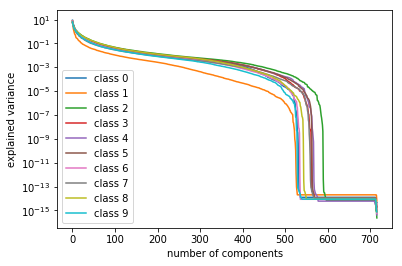

In [26]:
plt.figure()
for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      plt.semilogy(pca.explained_variance_, label='class %d'%jj)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.legend()
plt.show()

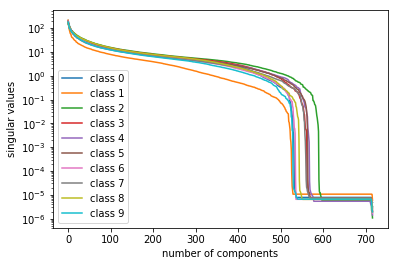

In [28]:
plt.figure()
for jj in range(10):
      pca, mask= pickle.load(open(pca_path+'pca_on_%d_num_comp_full.pkl'%(jj),'rb')) 
      plt.semilogy(pca.singular_values_, label='class %d'%jj)
plt.xlabel('number of components')
plt.ylabel('singular values')
plt.legend()
plt.show()